In [22]:
! pip install pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 53.7 MB/s eta 0:00:001m48.9 MB/s eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [pandas]━━━━━━━━━━━ 2/3 [pandas]


In [4]:
import cv2
import mediapipe as mp
import os
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import numpy as np
import mediapipe as mp
from tqdm import tqdm
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical


In [5]:
dataset_path = 'D:\\Project\\eyeGazeTrackingSystem\\EyeGazeTracking\\dataset'
label_map = {
    'top-left': 1, 'top-center': 2, 'top-right': 3,
    'middle-left': 4, 'center': 5, 'middle-right': 6,
    'bottom-left': 7, 'bottom-center': 8, 'bottom-right': 9
}

In [6]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True)

LEFT_EYE_INDICES = [33, 133]
RIGHT_EYE_INDICES = [362, 263]

I0000 00:00:1747729888.170497  549804 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1747729888.180295  550244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747729888.183197  550244 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [7]:
def get_eye_crop(image, landmarks, indices):
    h, w = image.shape[:2]
    pts = np.array([[int(landmarks[i].x * w), int(landmarks[i].y * h)] for i in indices])
    cx, cy = np.mean(pts, axis=0).astype(int)
    x1, y1 = cx - 100, cy - 75
    x2, y2 = cx + 100, cy + 75
    return image[y1:y2, x1:x2]
def process_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    if not results.multi_face_landmarks:
        return None

    landmarks = results.multi_face_landmarks[0].landmark
    left_eye = get_eye_crop(image, landmarks, LEFT_EYE_INDICES)
    right_eye = get_eye_crop(image, landmarks, RIGHT_EYE_INDICES)


    combined = np.hstack((left_eye, right_eye))
    return combined

In [55]:
path = 'dataset'
arr = {}
X=[]
y=[]
arr=['top-center','center','bottom-center']
for label in os.listdir(path):
    label_path = os.path.join(path,label)
    if label in arr:
        continue
    for img_name in os.listdir(label_path):
        img_path = os.path.join(label_path,img_name)
        processed = process_image(img_path)
        if processed is not None:
            X.append(processed)
            y.append(label_map[label])

X = np.array(X)
y = np.array(y)

In [35]:
X = []
y = []

for folder_name, label in label_map.items():
    folder_path = os.path.join(dataset_path, folder_name)
    print(folder_path)
    for file_name in tqdm(os.listdir(folder_path), desc=f"Processing {folder_name}"):
        image_path = os.path.join(folder_path, file_name)
        # print(image_path)
        processed = process_image(image_path)
        if processed is not None:
            X.append(processed)
            y.append(label_map[folder_name])

X = np.array(X)
y = np.array(y)

D:\Project\eyeGazeTrackingSystem\EyeGazeTracking\dataset\top-left


Processing top-left: 100%|████████████████████████████████████████████| 98/98 [00:07<00:00, 12.43it/s]


D:\Project\eyeGazeTrackingSystem\EyeGazeTracking\dataset\top-center


Processing top-center:  14%|█████▋                                    | 13/95 [00:01<00:06, 11.85it/s]


KeyboardInterrupt: 

In [56]:
print("Dataset created:")
print("X shape:", X.shape)  
print("y shape:", y.shape)  

Dataset created:
X shape: (1470, 150, 400, 3)
y shape: (1470,)


In [57]:
unique_values = np.unique(y).tolist()
unique_values

[1, 3, 4, 6, 7, 9]

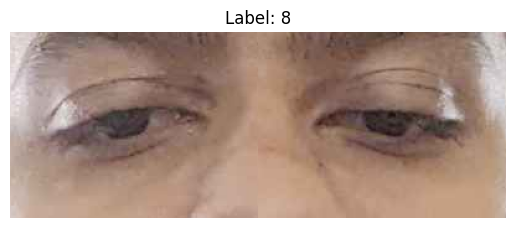

In [40]:
import matplotlib.pyplot as plt
import random

# Choose a random index
idx = random.randint(0, len(X) - 1)

# Show the image
plt.imshow(cv2.cvtColor(X[idx], cv2.COLOR_BGR2RGB))
plt.title(f"Label: {y[idx]}")
plt.axis('off')
plt.show()

In [58]:
X = np.array(X, dtype=np.float32) / 255.0  # Normalize
y = np.array(y)
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_cat = to_categorical(y_encoded, num_classes=6)


In [59]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.2, random_state=42, stratify=y_cat)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# 4. Define CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=X.shape[1:]),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(6, activation='softmax')
])

# 5. Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 6. Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# 7. Evaluate on test set
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

/Users/mananchavda/.pyenv/versions/3.10.13/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - accuracy: 0.1762 - loss: 1.7954 - val_accuracy: 0.1701 - val_loss: 1.7904
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - accuracy: 0.1718 - loss: 1.7932 - val_accuracy: 0.2177 - val_loss: 1.7884
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.2011 - loss: 1.7890 - val_accuracy: 0.1701 - val_loss: 1.7699
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.1893 - loss: 1.7754 - val_accuracy: 0.1837 - val_loss: 1.7343
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.2356 - loss: 1.7409 - val_accuracy: 0.3197 - val_loss: 1.6285
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3065 - loss: 1.6291 - val_accuracy: 0.2789 - val_loss: 1.5848
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3012 - loss: 1.5712 - val_accuracy: 0.3265 - val_loss: 1.4384
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - accuracy: 0.3118 - loss: 1.4950 - val_accuracy: 0.3537 - 

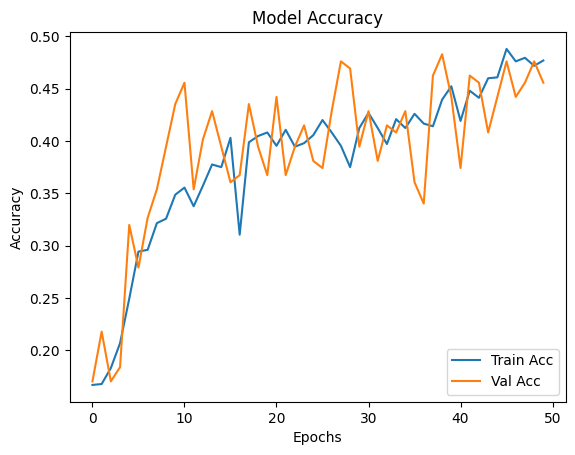

In [60]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [76]:
import os
import cv2
import numpy as np
import cv2
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

def calculate_white_ratio(image):
    results = face_mesh.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if not results.multi_face_landmarks:
        return None
    
    landmarks = results.multi_face_landmarks[0].landmark
    
    LEFT_EYE_IDS = [33, 133]   # Corners of left eye
    RIGHT_EYE_IDS = [362, 263] # Corners of right eye
    IRIS_LEFT = 468            # Iris center left
    IRIS_RIGHT = 473           # Iris center right

    h, w = image.shape[:2]

    try:
        left_start = int(landmarks[LEFT_EYE_IDS[0]].x * w)
        left_end = int(landmarks[LEFT_EYE_IDS[1]].x * w)
        iris_x = int(landmarks[IRIS_LEFT].x * w)
        left_ratio = (iris_x - left_start) / (left_end - left_start)

        right_start = int(landmarks[RIGHT_EYE_IDS[0]].x * w)
        right_end = int(landmarks[RIGHT_EYE_IDS[1]].x * w)
        iris_x_r = int(landmarks[IRIS_RIGHT].x * w)
        right_ratio = (iris_x_r - right_start) / (right_end - right_start)

        return [left_ratio, right_ratio]
    except:
        return None

folder_to_label = {
    'top-left': 1,
    'top-center': 2,
    'top-right': 3,
    'middle-left': 4,
    'center': 5,
    'middle-right': 6,
    'bottom-left': 7,
    'bottom-center': 8,
    'bottom-right': 9
}

data_dir = 'dataset'  # path to your dataset
image_paths = []
labels = []

for folder_name, label in folder_to_label.items():
    folder_path = os.path.join(data_dir, folder_name)
    # if folder_name in arr:
    #     continue
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png', '.jpeg')):
            image_paths.append(os.path.join(folder_path, filename))
            labels.append(label)

I0000 00:00:1747738443.041677  549804 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 89.4), renderer: Apple M4
W0000 00:00:1747738443.044416  603236 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1747738443.051958  603233 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [74]:
def generate(x):
    features = []
    final_labels = []
    
    for img_path, label in zip(image_paths, labels):
        img = cv2.imread(img_path)
        if img is None:
            continue
    
        img = cv2.resize(img, (x,x))  # ÷÷resize for consistency if needed
        ratio = calculate_white_ratio(img)
        
        if ratio:
            features.append(ratio)
            final_labels.append(label)
    
    X = np.array(features)
    y = np.array(final_labels)
    models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Network": MLPClassifier(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}

    # Prepare K-Fold
    k = 5
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Store results
    results = []
    
    for name, model in models.items():
        scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
        results.append({
            'Model': name,
            'Mean Accuracy': np.mean(scores),
            'Std Dev': np.std(scores)
        })
    
    # Display results
    results_df = pd.DataFrame(results)
    print("printing for " ,x," sized image") 
    results_df = results_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
    print(results_df)
    print("****************")

In [77]:
for x in [100,200,300,400,500,600,700,800]:
    generate(x)

printing for  100  sized image
                          Model  Mean Accuracy   Std Dev
0                 Random Forest       0.205987  0.008369
1                 Decision Tree       0.201001  0.004781
2             Gradient Boosting       0.193735  0.005362
3              SVM (RBF Kernel)       0.167879  0.012450
4                      AdaBoost       0.167429  0.019848
5                   Naive Bayes       0.149260  0.030280
6            MLP Neural Network       0.145186  0.010175
7  Linear Discriminant Analysis       0.137469  0.013874
8           Logistic Regression       0.136556  0.016098
9           K-Nearest Neighbors       0.132034  0.017769
****************
printing for  200  sized image
                          Model  Mean Accuracy   Std Dev
0             Gradient Boosting       0.284015  0.021837
1                 Random Forest       0.277664  0.023104
2                 Decision Tree       0.276305  0.023596
3           K-Nearest Neighbors       0.215065  0.011263
4        

In [72]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import pandas as pd
import numpy as np

# Set up models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM (RBF Kernel)": SVC(kernel='rbf'),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Naive Bayes": GaussianNB(),
    "MLP Neural Network": MLPClassifier(max_iter=1000),
    "Linear Discriminant Analysis": LinearDiscriminantAnalysis()
}

# Prepare K-Fold
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Store results
results = []

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')
    results.append({
        'size':x,
        'Model': name,
        'Mean Accuracy': np.mean(scores),
        'Std Dev': np.std(scores)
    })

# Display results
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
print(results_df)

/Users/mananchavda/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


                          Model  Mean Accuracy   Std Dev
0                 Random Forest       0.525170  0.024395
1                 Decision Tree       0.515646  0.024395
2             Gradient Boosting       0.507483  0.021011
3           K-Nearest Neighbors       0.444898  0.024090
4                      AdaBoost       0.336735  0.019833
5              SVM (RBF Kernel)       0.331293  0.026574
6  Linear Discriminant Analysis       0.318367  0.026224
7            MLP Neural Network       0.314286  0.032809
8                   Naive Bayes       0.309524  0.029652
9           Logistic Regression       0.252381  0.026294


/Users/mananchavda/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [133]:
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import numpy as np

def apply_filters(img):
    filters = {}
    filters['original'] = img
    filters['gaussian'] = cv2.GaussianBlur(img, (5, 5), 0)
    filters['sobel'] = cv2.Sobel(img, cv2.CV_64F, 1, 1, ksize=3)
    filters['laplacian'] = cv2.Laplacian(img, cv2.CV_64F)
    
    # Convert image to uint8 if needed
    if img.dtype != np.uint8:
        img_uint8 = cv2.convertScaleAbs(img)
    else:
        img_uint8 = img
    
    filters['median'] = cv2.medianBlur(img_uint8, 5)
    
    return filters


def build_cnn_model(input_shape, model_type='basic'):
    model = models.Sequential()
    if model_type == 'basic':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    elif model_type == 'deep':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(128, (3,3), activation='relu'))
        model.add(layers.MaxPooling2D((2,2)))
    elif model_type == 'dropout':
        model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape))
        model.add(layers.MaxPooling2D((2,2)))
        model.add(layers.Conv2D(64, (3,3), activation='relu'))
        model.add(layers.Dropout(0.3))
        model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(len(np.unique(y)), activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


In [149]:
from sklearn.model_selection import KFold
from tensorflow.keras.utils import to_categorical

kf = KFold(n_splits=5, shuffle=True, random_state=42)
input_shape = (100, 200, 1)

cnn_models = ['basic', 'deep', 'dropout']
filter_types = ['original', 'gaussian', 'sobel', 'laplacian']

results = []

for filter_name in filter_types:
    # Apply filter to all images
    X_filtered = np.array([apply_filters(img)[filter_name] for img in X])
    X_filtered = X_filtered.astype('float32') / 255.0
    X_filtered = []

    for img_left, img_right in X:
        combined = np.concatenate([img_left, img_right], axis=1)
        
        X_filtered.append(combined)
    
    X_filtered = np.array(X_filtered)
    X_filtered = X_filtered.reshape(-1, 100, 200, 1).astype('float32') / 255.0


    for model_type in cnn_models:
        acc_scores = []
        for train_index, test_index in kf.split(X_filtered):
            model = build_cnn_model(input_shape, model_type)
            X_train, X_test = X_filtered[train_index], X_filtered[test_index]
            y_train, y_test = y[train_index], y[test_index]
            model.fit(X_train, y_train, epochs=5, verbose=0, batch_size=32)
            _, acc = model.evaluate(X_test, y_test, verbose=0)
            acc_scores.append(acc)
        results.append({
            'Filter': filter_name,
            'Model': model_type,
            'Mean Accuracy': np.mean(acc_scores),
            'Std Dev': np.std(acc_scores)
        })


ValueError: zero-dimensional arrays cannot be concatenated

In [ ]:

import pandas as pd

df = pd.DataFrame(results)
df = df.sort_values(by='Mean Accuracy', ascending=False).reset_index(drop=True)
print(df)
